# QNN Encoding Comparison

We compare different encoding methods in a minimal QNN classifier setup.
Only the encoding changes — dataset, ansatz, optimizer, and training budget remain fixed.

Encodings to compare:
- basis
- angle
- angle_reupload
- amplitude

In [ ]:
from pathlib import Path
import numpy as np
import os
import sys
import math
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data import make_linear, train_test_split, standardize_fit_transform
from src.qnn import train_qnn, predict_value, DEFAULT_ANSATZ

from src.encodings import BasisEncoding, AngleEncoding, ReuploadingAngleEncoding, AmplitudeEncoding

GLOBAL_SEED = 0

N_SAMPLES = 250
DATA_NOISE = 0.30
TEST_RATIO = 0.30

SEEDS = list(range(10))
MAXITER = 150
LOG_EVERY = 5

ANSATZ_CFG = DEFAULT_ANSATZ      # n_qubits=2, layers=2

results_dir = PROJECT_ROOT / "results" / "qnn"
results_dir.mkdir(parents=True, exist_ok=True)

In [12]:
X, y01 = make_linear(n=N_SAMPLES, seed=GLOBAL_SEED, noise=DATA_NOISE)

split = train_test_split(X, y01, test_ratio=TEST_RATIO, seed=GLOBAL_SEED)

X_train, X_test = standardize_fit_transform(split.X_train, split.X_test)

def y01_to_pm1(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y, dtype=int)
    return (2 * y - 1).astype(float)  # 0 -> -1, 1 -> +1

y_train = y01_to_pm1(split.y_train)
y_test  = y01_to_pm1(split.y_test)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Label counts (train):", {v: int(np.sum(y_train == v)) for v in [-1.0, +1.0]})

Train: (175, 2) (175,)
Test : (75, 2) (75,)
Label counts (train): {-1.0: 89, 1.0: 86}


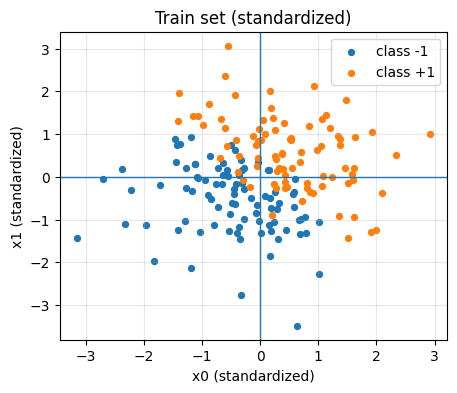

In [28]:
plt.figure(figsize=(5, 4))
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], s=18, label="class -1")
plt.scatter(X_train[y_train == +1, 0], X_train[y_train == +1, 1], s=18, label="class +1")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("x0 (standardized)")
plt.ylabel("x1 (standardized)")
plt.title("Train set (standardized)")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(results_dir / "03_train_data_scatter.png")
plt.show()

In [ ]:
N_FEATURES = X_train.shape[1]
N_QUBITS_EXPECTED = ANSATZ_CFG.n_qubits

encoders = [
    BasisEncoding(threshold=0.0),
    AngleEncoding(angle_range=(-np.pi, np.pi)),
    ReuploadingAngleEncoding(reps=3, entangle=True, angle_range=(-np.pi, np.pi)),
    AmplitudeEncoding(fixed_n_qubits=N_QUBITS_EXPECTED),
]

for enc in encoders:
    nq = enc.n_qubits(N_FEATURES)
    if nq != N_QUBITS_EXPECTED:
        raise ValueError(
            f"Encoder '{enc.name}' uses {nq} qubits for n_features={N_FEATURES}, "
            f"but QNN expects {N_QUBITS_EXPECTED}. "
            f"Fix encoder config (e.g., AmplitudeEncoding(fixed_n_qubits=...))."
        )

x0 = X_train[0]
for enc in encoders:
    qc = enc.circuit(x0)
    if qc.num_qubits != N_QUBITS_EXPECTED:
        raise ValueError(
            f"Encoder '{enc.name}' produced circuit with {qc.num_qubits} qubits "
            f"(expected {N_QUBITS_EXPECTED})."
        )

print("Encoders:", [e.name for e in encoders])


Encoders: ['basis', 'angle', 'angle_reupload', 'amplitude']


In [ ]:
def predict_label_from_value(v: float) -> float:
    # map Z in [-1,1] -> class in {-1,+1}
    return +1.0 if v >= 0.0 else -1.0

def accuracy(encoder, theta, X, y_pm1) -> float:
    preds = np.array([predict_value(encoder, x, theta, ansatz_cfg=ANSATZ_CFG) for x in X], dtype=float)
    pred_labels = np.array([predict_label_from_value(v) for v in preds], dtype=float)
    return float(np.mean(pred_labels == y_pm1))

results = []

for enc in encoders:
    print(f"\n=== Encoding: {enc.name} ===")

    for seed in SEEDS:
        tr = train_qnn(
            encoder=enc,
            X=X_train,
            y=y_train,
            seed=seed,
            maxiter=MAXITER,
            ansatz_cfg=ANSATZ_CFG,
            log_every=LOG_EVERY,
        )

        train_acc = accuracy(enc, tr.theta_star, X_train, y_train)
        test_acc = accuracy(enc, tr.theta_star, X_test, y_test)

        results.append({
            "encoding": enc.name,
            "seed": seed,
            "success": tr.success,
            "message": tr.message,
            "theta_star": tr.theta_star,
            "loss_history": tr.loss_history,
            "train_acc": train_acc,
            "test_acc": test_acc,
        })

    enc_test_accs = [r["test_acc"] for r in results if r["encoding"] == enc.name]
    print(f"Mean test acc ({enc.name}): {np.mean(enc_test_accs):.3f} ± {np.std(enc_test_accs):.3f}")


=== Encoding: basis ===
Mean test acc (basis): 0.693 ± 0.000

=== Encoding: angle ===
Mean test acc (angle): 0.480 ± 0.000

=== Encoding: angle_reupload ===
Mean test acc (angle_reupload): 0.480 ± 0.000

=== Encoding: amplitude ===
Mean test acc (amplitude): 0.485 ± 0.016


## Prepare Plots

In [ ]:
def group_by_encoding(results):
    by = {}
    for r in results:
        by.setdefault(r["encoding"], []).append(r)
    return by

by_enc = group_by_encoding(results)
enc_names = sorted(by_enc.keys())
print("Encodings:", enc_names)

def mean_std(xs):
    xs = np.asarray(xs, dtype=float)
    return float(xs.mean()), float(xs.std(ddof=0))

def pad_to_same_length(curves, fill_value=np.nan):
    """
    Pad a list of 1D lists to equal length with NaNs.
    Returns (arr, maxlen) where arr shape = (n_curves, maxlen)
    """
    maxlen = max(len(c) for c in curves)
    arr = np.full((len(curves), maxlen), fill_value, dtype=float)
    for i, c in enumerate(curves):
        arr[i, :len(c)] = np.asarray(c, dtype=float)
    return arr, maxlen

Encodings: ['amplitude', 'angle', 'angle_reupload', 'basis']


Saved /home/lucas/uni/semester5/fqc/final_project/results/qnn/03_test_acc.png


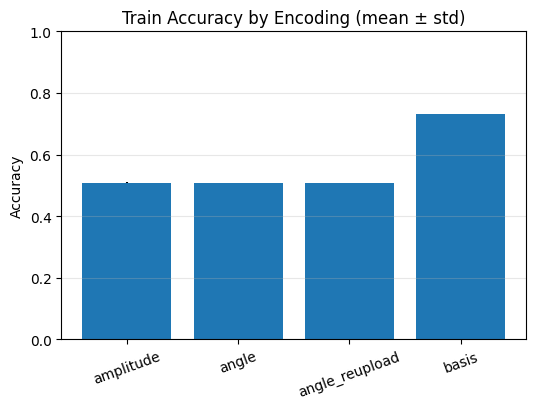

In [29]:
def plot_acc_bar(by_enc, key="test_acc", title="Test Accuracy by Encoding", filename=None):
    labels = []
    means = []
    stds = []

    for enc in sorted(by_enc.keys()):
        vals = [r[key] for r in by_enc[enc]]
        m, s = mean_std(vals)
        labels.append(enc)
        means.append(m)
        stds.append(s)

    plt.figure(figsize=(6, 4))
    plt.bar(labels, means, yerr=stds)
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)
    plt.xticks(rotation=20)

    if filename is not None:
        path = results_dir / filename
        plt.savefig(path, dpi=200, bbox_inches="tight")
        print("Saved", path)

    plt.show()

plot_acc_bar(by_enc, key="train_acc", title="Train Accuracy by Encoding (mean ± std)", filename="03_test_acc.png")

Saved /home/lucas/uni/semester5/fqc/final_project/results/qnn/03_loss_curves.png


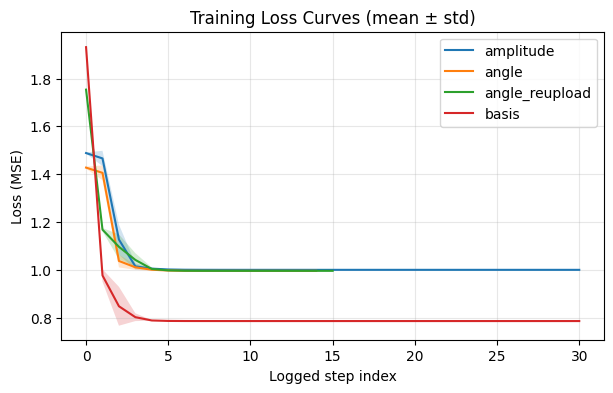

In [30]:
def plot_loss_curves(by_enc, title="Training Loss Curves (mean ± std)", filename=None):
    plt.figure(figsize=(7, 4))

    for enc in sorted(by_enc.keys()):
        curves = [r["loss_history"] for r in by_enc[enc] if r.get("loss_history") is not None]
        if len(curves) == 0:
            continue

        arr, maxlen = pad_to_same_length(curves, fill_value=np.nan)
        mean_curve = np.nanmean(arr, axis=0)
        std_curve  = np.nanstd(arr, axis=0)

        xs = np.arange(maxlen)
        plt.plot(xs, mean_curve, label=enc)
        plt.fill_between(xs, mean_curve - std_curve, mean_curve + std_curve, alpha=0.2)

    plt.xlabel("Logged step index")
    plt.ylabel("Loss (MSE)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()

    if filename is not None:
        path = results_dir / filename
        plt.savefig(path, dpi=200, bbox_inches="tight")
        print("Saved", path)

    plt.show()

plot_loss_curves(by_enc, filename="03_loss_curves.png")

Saved /home/lucas/uni/semester5/fqc/final_project/results/qnn/03_decision_boundaries_grid.png


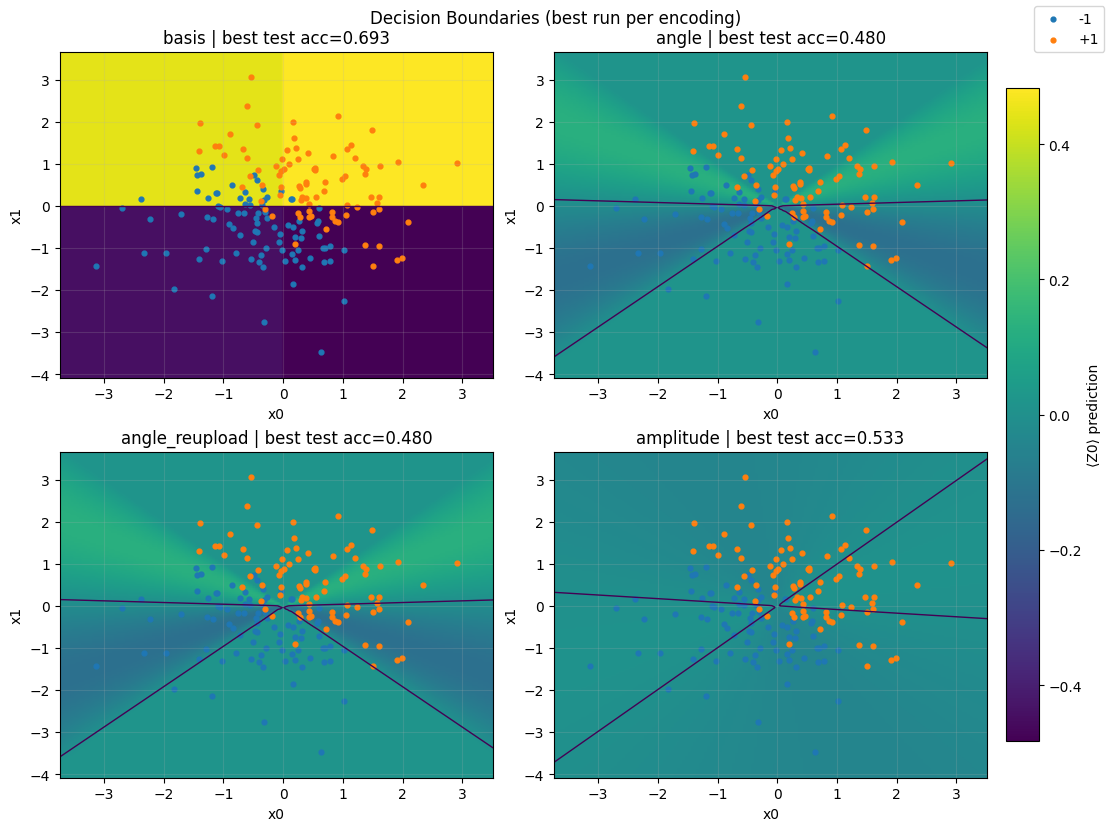

In [31]:
def find_best_run(by_enc, enc_name, key="test_acc"):
    runs = by_enc[enc_name]
    def score(r):
        last_loss = r["loss_history"][-1] if r.get("loss_history") else np.inf
        return (r.get(key, -np.inf), -last_loss)
    return max(runs, key=score)

def decision_surface(enc, theta, X_ref, grid_n=160):
    x0_min, x0_max = X_ref[:, 0].min() - 0.6, X_ref[:, 0].max() + 0.6
    x1_min, x1_max = X_ref[:, 1].min() - 0.6, X_ref[:, 1].max() + 0.6

    xs = np.linspace(x0_min, x0_max, grid_n)
    ys = np.linspace(x1_min, x1_max, grid_n)
    xx, yy = np.meshgrid(xs, ys)

    grid = np.c_[xx.ravel(), yy.ravel()]
    vals = np.array(
        [predict_value(enc, p, theta, ansatz_cfg=ANSATZ_CFG) for p in grid],
        dtype=float
    )
    zz = vals.reshape(xx.shape)
    extent = (x0_min, x0_max, x1_min, x1_max)
    return xx, yy, zz, extent

def plot_decision_grid(encoders, by_enc, X_train, y_train,
                       title="Decision Boundaries (best run per encoding)",
                       filename=None,
                       clip_percentile=99):
    enc_map = {e.name: e for e in encoders}
    names = [e.name for e in encoders]
    n = len(names)
    cols = 2
    rows = int(math.ceil(n / cols))

    surfaces = {}
    pooled_vals = []
    extent0 = None

    for name in names:
        if name not in by_enc:
            continue
        best = find_best_run(by_enc, name, key="test_acc")
        theta = best["theta_star"]
        enc = enc_map[name]

        xx, yy, zz, extent = decision_surface(enc, theta, X_train, grid_n=160)
        surfaces[name] = (best, xx, yy, zz, extent)
        pooled_vals.append(np.abs(zz).ravel())

        if extent0 is None:
            extent0 = extent

    if len(surfaces) == 0:
        print("No surfaces to plot.")
        return

    pooled_vals = np.concatenate(pooled_vals)

    if clip_percentile is not None:
        vmax = float(np.percentile(pooled_vals, clip_percentile))
        vmax = max(vmax, 1e-6)
        vmin = -vmax
    else:
        all_z = np.concatenate([surfaces[name][3].ravel() for name in surfaces])
        vmin = float(np.min(all_z))
        vmax = float(np.max(all_z))
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m

    fig, axes = plt.subplots(rows, cols, figsize=(11, 8), constrained_layout=True)
    fig.suptitle(title, y=1.02)

    mappable = None

    for i, name in enumerate(names):
        ax = axes[i // cols][i % cols]

        if name not in surfaces:
            ax.set_title(f"{name} (no runs)")
            ax.axis("off")
            continue

        best, xx, yy, zz, extent = surfaces[name]
        x0_min, x0_max, x1_min, x1_max = extent

        im = ax.imshow(
            zz,
            origin="lower",
            extent=[x0_min, x0_max, x1_min, x1_max],
            aspect="auto",
            vmin=vmin,
            vmax=vmax,
        )
        mappable = im

        ax.contour(xx, yy, zz, levels=[0.0], linewidths=1)

        ax.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], s=12, label="-1")
        ax.scatter(X_train[y_train == +1, 0], X_train[y_train == +1, 1], s=12, label="+1")

        ax.set_title(f"{name} | best test acc={best['test_acc']:.3f}")
        ax.set_xlabel("x0")
        ax.set_ylabel("x1")
        ax.grid(alpha=0.2)

    for j in range(n, rows * cols):
        axes[j // cols][j % cols].axis("off")

    if mappable is not None:
        cbar = fig.colorbar(mappable, ax=axes, shrink=0.9, pad=0.02)
        cbar.set_label("⟨Z0⟩ prediction")

    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    if filename is not None:
        path = results_dir / filename
        plt.savefig(path, dpi=200, bbox_inches="tight")
        print("Saved", path)

    plt.show()

plot_decision_grid(encoders, by_enc, X_train, y_train, filename="03_decision_boundaries_grid.png", clip_percentile=99)

In [25]:
for enc in sorted(by_enc.keys()):
    test_accs = [r["test_acc"] for r in by_enc[enc]]
    train_accs = [r["train_acc"] for r in by_enc[enc]]
    m_te, s_te = mean_std(test_accs)
    m_tr, s_tr = mean_std(train_accs)
    print(f"{enc:14s}  test_acc={m_te:.3f}±{s_te:.3f}   train_acc={m_tr:.3f}±{s_tr:.3f}")

amplitude       test_acc=0.485±0.016   train_acc=0.508±0.002
angle           test_acc=0.480±0.000   train_acc=0.509±0.000
angle_reupload  test_acc=0.480±0.000   train_acc=0.509±0.000
basis           test_acc=0.693±0.000   train_acc=0.731±0.000
